In [96]:
from IPython.display import Image

# Continuous Factors

1. Base Class for Continuous Factors
2. Joint Gaussian Distributions
3. Canonical Factors
4. Linear Gaussian CPD

In many situations, some variables are best modeled as taking values in some continuous space. Examples include variables such as position, velocity, temperature, and pressure. Clearly, we cannot use a table representation in this case. 

Nothing in the formulation of a Bayesian network requires that we restrict attention to discrete variables. The only requirement is that the CPD, P(X | Y1, Y2, ... Yn) represent, for every assignment of values y1 ∈ Val(Y1), y2 ∈ Val(Y2), .....yn ∈ val(Yn), a distribution over X. In this case, X might be continuous, in which case the CPD would need to represent distributions over a continuum of values; we might also have X’s parents continuous, so that the CPD would also need to represent a continuum of different probability distributions. There exists implicit representations for CPDs of this type, allowing us to apply all the network machinery for the continuous case as well.

### Base Class for Continuous Factors

This class will behave as a base class for the continuous factor representations. All the present and future factor classes will be derived from this base class. We need to specify the variable names and a pdf function to initialize this class.

In [97]:
import numpy as np
from scipy.special import beta

# Two variable drichlet ditribution with alpha = (1,2)
def drichlet_pdf(x, y):
     return (np.power(x, 1)*np.power(y, 2))/beta(x, y)

from pgmpy.factors import ContinuousFactor
drichlet_factor = ContinuousFactor(['x', 'y'], drichlet_pdf)

In [98]:
drichlet_factor.scope(), drichlet_factor.assignment(5,6)

(['x', 'y'], 226800.0)

This class supports methods like **marginalize, reduce, product and divide** just like what we have with discrete classes. One caveat is that when there are a number of variables involved, these methods prove to be inefficient and hence we resort to certain Gaussian or some other approximations which are discussed later.

In [99]:
def custom_pdf(x, y, z):
    return z*(np.power(x, 1)*np.power(y, 2))/beta(x, y)

custom_factor = ContinuousFactor(['x', 'y', 'z'], custom_pdf)

In [100]:
custom_factor.scope(), custom_factor.assignment(1, 2, 3)

(['x', 'y', 'z'], 24.0)

In [101]:
custom_factor.reduce([('y', 2)])
custom_factor.scope(), custom_factor.assignment(1, 3)

(['x', 'z'], 24.0)

In [102]:
from scipy.stats import multivariate_normal

std_normal_pdf = lambda *x: multivariate_normal.pdf(x, [0, 0], [[1, 0], [0, 1]])
std_normal = ContinuousFactor(['x1', 'x2'], std_normal_pdf)
std_normal.scope(), std_normal.assignment([1, 1])

(['x1', 'x2'], 0.058549831524319168)

In [103]:
std_normal.marginalize(['x2'])
std_normal.scope(), std_normal.assignment(1)

(['x1'], 0.24197072451914328)

In [104]:
sn_pdf1 = lambda x: multivariate_normal.pdf([x], [0], [[1]])
sn_pdf2 = lambda x1,x2: multivariate_normal.pdf([x1, x2], [0, 0], [[1, 0], [0, 1]])
sn1 = ContinuousFactor(['x2'], sn_pdf1)
sn2 = ContinuousFactor(['x1', 'x2'], sn_pdf2)
sn3 = sn1 * sn2
sn4 = sn2 / sn1
sn3.assignment(0, 0), sn4.assignment(0, 0)

(0.063493635934240983, 0.3989422804014327)

The ContinuousFactor class also has a method **discretize** that takes a pgmpy Discretizer class as input. It will output a list of discrete probability masses or a Factor or TabularCPD object depending upon the discretization method used. Although, we do not have inbuilt discretization algorithms for multivariate distributions for now, the users can always define their own Discretizer class by subclassing the pgmpy.BaseDiscretizer class.

### Joint Gaussian Distributions

In its most common representation, a multivariate Gaussian distribution over X1………..Xn is characterized by an n-dimensional mean vector μ, and a symmetric n x n covariance matrix Σ. The density function is most defined as -

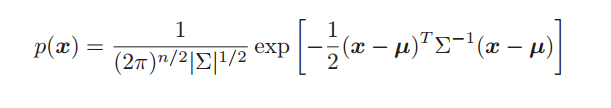

In [116]:
Image(filename='../images/continuous/joint_gaussian_pdf.png')

The class pgmpy.JointGaussianDistribution provides its representation. This is derived from the class pgmpy.ContinuousFactor. We need to specify the variable names, a mean vector and a covariance matrix for its inialization. It will automatically comute the pdf function given these parameters.

In [107]:
from pgmpy.factors import JointGaussianDistribution as JGD
dis = JGD(['x1', 'x2', 'x3'], np.array([[1], [-3], [4]]),
          np.array([[4, 2, -2], [2, 5, -5], [-2, -5, 8]]))
dis.variables
dis.mean
dis.covariance
dis.pdf([0,0,0])

0.0014805631279234139

In [108]:
dis.mean

array([[ 1.],
       [-3.],
       [ 4.]])

In [109]:
dis.covariance

array([[ 4.,  2., -2.],
       [ 2.,  5., -5.],
       [-2., -5.,  8.]])

In [110]:
dis.pdf([0,0,0])

0.0014805631279234139

This class overrides the basic operation methods **(marginalize, reduce, normalize, product and divide)** as these operations here are more efficient than the ones in its parent class. Most of these operation involve a matrix inversion which is O(n^3) with repect to the number of variables.

In [111]:
dis1 = JGD(['x1', 'x2', 'x3'], np.array([[1], [-3], [4]]),
           np.array([[4, 2, -2], [2, 5, -5], [-2, -5, 8]]))
dis2 = JGD(['x3', 'x4'], [1, 2], [[2, 3], [5, 6]])
dis3 = dis1 * dis2
dis3.scope()

['x1', 'x2', 'x3', 'x4']

In [112]:
dis3.mean

array([[ 1.6],
       [-1.5],
       [ 1.6],
       [ 3.5]])

In [113]:
dis3.covariance

array([[ 3.6,  1. , -0.4, -0.6],
       [ 1. ,  2.5, -1. , -1.5],
       [-0.4, -1. ,  1.6,  2.4],
       [-1. , -2.5,  4. ,  4.5]])

The others methods can also be used in a similar fashion.

### Canonical Factors

While the Joint Gaussian representation is useful for certain sampling algorithms, a closer look reveals that it can also not be used directly in the sum-product algorithms. Why? Because operations like product and reduce, as mentioned above involve matrix inversions at each step. 

So, in order to compactly describe the intermediate factors in a Gaussian network without the costly matrix inversions at each step, a simple parametric representation is used known as the Canonical Factor. This representation is closed under the basic operations used in inference: factor product, factor division, factor reduction, and marginalization. Thus, we can define a set of simple data structures that allow the inference process to be performed. Moreover, the integration operation required by marginalization is always well defined, and it is guaranteed to produce a finite integral under certain conditions; when it is well defined, it has a simple analytical solution.

A canonical form C (X; K,h, g) is defined as:

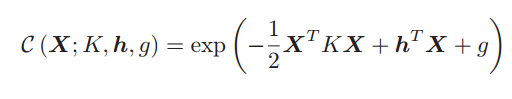

In [118]:
Image(filename='../images/continuous/canonical_representation.png')

We can represent every Gaussian as a canonical form. Rewriting the joint Gaussian pdf we obtain,

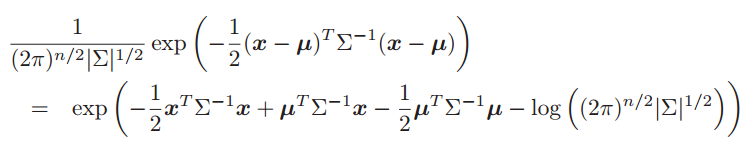

In [119]:
Image(filename='../images/continuous/canonical2.png')

Thus, N (μ; Σ) = C (K, h, g) where:

$$
K = Σ^{-1}
$$
$$
h = Σ^{-1}μ
$$
$$
g = -0.5μ^TΣ^{-1}μ - log((2π)^{n/2}|Σ|^{1/2}
$$

Similar to the JointGaussainDistribution class, the CanonicalFactor class is also derived from the ContinuousFactor class but with its own implementations of the methods required for the sum-product algorithms that are much more efficient than its parent class methods. Let us have a look at the API of a few methods in this class.

In [122]:
from pgmpy.factors import CanonicalFactor
phi1 = CanonicalFactor(['x1', 'x2', 'x3'],
                       np.array([[1, -1, 0], [-1, 4, -2], [0, -2, 4]]),
                       np.array([[1], [4], [-1]]), -2)
phi2 = CanonicalFactor(['x1', 'x2'], np.array([[3, -2], [-2, 4]]),
                       np.array([[5], [-1]]), 1)

phi3 = phi1 * phi2
phi3.scope()

['x1', 'x2', 'x3']

In [123]:
phi3.h

array([[ 6.],
       [ 3.],
       [-1.]])

In [124]:
phi3.K

array([[ 4., -3.,  0.],
       [-3.,  8., -2.],
       [ 0., -2.,  4.]])

In [126]:
phi3.g

-1

This class also has a method, to_joint_gaussian to convert the canoncial representation back into the joint gaussian distribution.

In [127]:
phi = CanonicalFactor(['x1', 'x2'], np.array([[3, -2], [-2, 4]]),
                      np.array([[5], [-1]]), 1)
jgd = phi.to_joint_gaussian()
jgd.variables

['x1', 'x2']

In [128]:
jgd.covariance

array([[ 0.5  ,  0.25 ],
       [ 0.25 ,  0.375]])

In [129]:
jgd.mean

array([[ 2.25 ],
       [ 0.875]])

### Linear Gaussian CPD

A linear gaussian conditional probability distribution is defined on a continuous variable. All the parents of this variable are also continuous. The mean of this variable, is linearly dependent on the mean of its parent variables and the variance is independent.

For example,
$$
P(Y ; x1, x2, x3) = N(β_1x_1 + β_2x_2 + β_3x_3 + β_0 ; σ^2)
$$

Let Y be a linear Gaussian of its parents X1,...,Xk:
$$
p(Y | x) = N(β_0 + β^T x ; σ^2)
$$

The distribution of Y is a normal distribution p(Y) where:
$$
μ_Y = β_0 + β^Tμ
$$
$$
{{σ^2}_Y = σ^2 + β^TΣβ}
$$

The joint distribution over {X, Y} is a normal distribution where:

$$Cov[X_i; Y] = {\sum_{j=1}^{k} β_jΣ_{i,j}}$$

Assume that X1,...,Xk are jointly Gaussian with distribution N (μ; Σ). Then:
For its representation pgmpy has a class named LinearGaussianCPD in the module pgmpy.factors.continuous. To instantiate an object of this class, one needs to provide a variable name, the value of the beta_0 term, the variance, a list of the parent variable names and a list of the coefficient values of the linear equation (beta_vector), where the list of parent variable names and beta_vector list is optional and defaults to None.

In [9]:
# For P(Y| X1, X2, X3) = N(-2x1 + 3x2 + 7x3 + 0.2; 9.6)
from pgmpy.factors import LinearGaussianCPD
cpd = LinearGaussianCPD('Y', 0.2, 9.6, ['X1', 'X2', 'X3'], [-2, 3, 7])
print(cpd)

P(Y| X1, X2, X3) = N(-2*X1_mu + 3*X2_mu + 7*X3_mu; 0.2)


A Gaussian Bayesian is defined as a network all of whose variables are continuous, and where all of the CPDs are linear Gaussians. These networks are of particular interest as these are an alternate form of representaion of the Joint Gaussian distribution.

These networks are implemented as the LinearGaussianBayesianNetwork class in the module, pgmpy.models.continuous. This class is a subclass of the BayesianModel class in pgmpy.models and will inherit most of the methods from it. It will have a special method known as to_joint_gaussian that will return an equivalent JointGuassianDistribution object for the model.

In [4]:
from pgmpy.models import LinearGaussianBayesianNetwork
model = LinearGaussianBayesianNetwork([('x1', 'x2'), ('x2', 'x3')])
cpd1 = LinearGaussianCPD('x1', 1, 4)
cpd2 = LinearGaussianCPD('x2', -5, 4, ['x1'], [0.5])
cpd3 = LinearGaussianCPD('x3', 4, 3, ['x2'], [-1])
model.add_cpds(cpd1, cpd2, cpd3)
jgd = model.to_joint_gaussian()
jgd.variables

['x1', 'x2', 'x3']

In [5]:
jgd.mean

array([[ 1. ],
       [-4.5],
       [ 8.5]])

In [6]:
jgd.covariance

array([[ 4.,  2., -2.],
       [ 2.,  5., -5.],
       [-2., -5.,  8.]])